---
author: "Shah"
title: "MS-GARCH : Three Regime Markov Switching GJR and FI GARCH"
date: 10/15/2025
date-format: "MMM D, YYYY"
format:
#   docx: default
  html: 
      code-fold: false
jupyter: python3
html-math-method: katex
---

# Introduction
Model : Two State MS GJR GARCH with Poisson Jumps
First, to clarify what the possion jump does for this model. 
We add a jump term to the conditional variance before computing densities of the Markov switch. We are de-meaning the returns by the expected jump and adding jump variance on top of the diffusive variance. Our $h_t$ is the diffusion and not the entire variance itself.
The model assumes mean :$u_t = r_t - \lambda\mu J$

With this diffusion + jump set up. It seems like we add the jump term to the return (shock) part for likelihood but we just separate it to eat up the noise. We then model the rest of the series with the MS model.
This gives the model a bigger variance apetite for higher volatility securities.

## Data
We use minutely data spanning 2025-09-03 to 2025-10-17 downloaded from yfinance.

In [1]:
import numpy as np
from arch import arch_model
import pandas as pd
import yfinance as yf 
from scipy.optimize import minimize
import pandas as pd
from math import sqrt, pi, exp

# New ticker names for calling global variables. dash changed to underscore.
tickers = ["AAPL","BP","BRK_B","BTC_USD","CIFR","CNTA","COP","CVX", "IREN","JPM","LUMN","META","MPC","NVDA","OXY","PSX","RIOT", "SHEL","TSLA","VLO","XOM"]

# READING CONCATED DATA UNTIL G
for t in tickers:
    globals()[f"d_{t}"] = pd.read_pickle(f"./G_concat_prices/G_{t}.pkl")

In [2]:
for t in tickers:
    data = globals()[f"d_{t}"]
    split = int(len(data) * 80)
    globals()[f"train_{t}"] = data[:split] 
    globals()[f"test_{t}"] = data[split:]

In [3]:
for t in tickers:
    globals()[f"d_{t}"]['Close'] = pd.to_numeric(globals()[f"d_{t}"]['Close'] , errors= "coerce")

for t in tickers:
    globals()[f"y_{t}"] = globals()[f"d_{t}"]['Close']

for t in tickers:
    arr = globals()[f"y_{t}"].to_numpy(dtype=float)   # convert to numeric array
    globals()[f"r_{t}"] = pd.Series(np.log(arr)).diff().dropna() *100

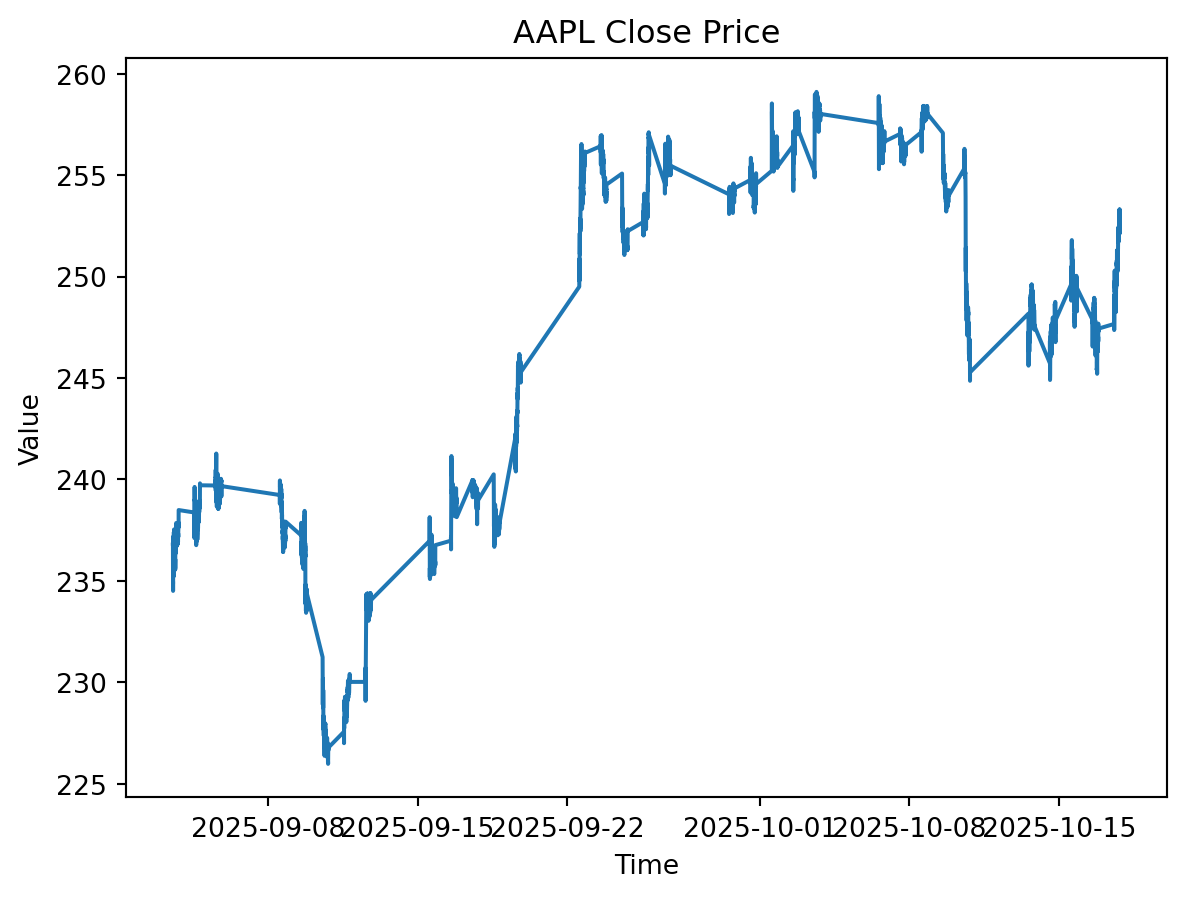

In [4]:
#|echo: false
import matplotlib.pyplot as plt
plt.plot(pd.to_numeric(y_AAPL))
plt.title("AAPL Close Price")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()


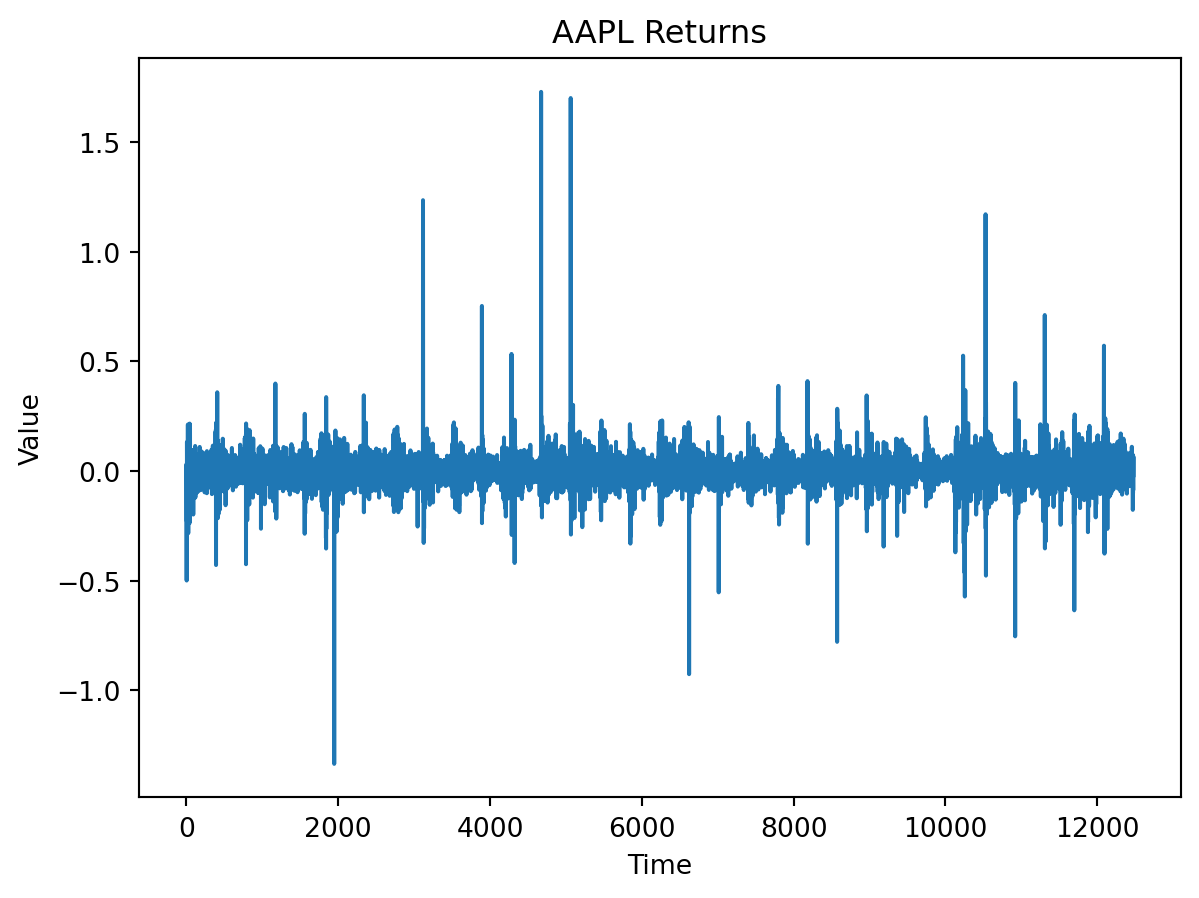

In [5]:
#|echo: false
import matplotlib.pyplot as plt
plt.plot(pd.to_numeric(r_AAPL))
plt.title("AAPL Returns")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

## MS GJR-GARCH with (Poisson Jumps) - Model

### Regime equations (mdl03)
$$
h_{t+1}^{(0)} = \omega_0 + (\alpha_0 + \gamma_0\,\mathbf{1}\{u_t < 0\})(u_t^2 + \lambda\sigma_J^2) + \beta_0\,h_t^{(0)}
$$

$$
h_{t+1}^{(1)} = \omega_1 + (\alpha_1 + \gamma_1\,\mathbf{1}\{u_t < 0\})(u_t^2 + \lambda\sigma_J^2) + \beta_1\,h_t^{(1)}
$$

where $u_t = r_t - \lambda\mu_J$ represents the jump-adjusted innovation.

Variance in likelihood is the sum of diffusive variance $h_t(j)$ plus jump variance.

### Regime filter

$$
\ell_j = f(r_t \mid s_t=j)
$$

$$
\pi_{t|t}(j)=\frac{\pi_{t|t-1}(j)\,\ell_j}{\sum_{k}\pi_{t|t-1}(k)\,\ell_k}
$$


$$
\pi_{t+1|t}(j)=\sum_i \pi_{t|t}(i)P_{ij}\quad\text{(i.e., }\pi_{t+1|t}=\pi_{t|t}P\text{)}
$$

$$
\ell_j = f(r_t \mid s_t=j)
$$


# Model Main

## Setting up initial transition matrix and other important functions

In [6]:
######### PLAIN MARKOV SWITCHING MODEL
R = 2  # number of regimes
P = np.array([[0.95, 0.05],   # transition matrix
              [0.10, 0.90]])  # rows sum to 1

pi_0 = np.full(R, 1.0/R)   # start equal across regimes

# each regime j has [omega, alpha, beta]
params = {
    0: [0.01, 0.05, 0.90],
    1: [0.02, 0.10, 0.80]
}

def sigmoid(x):
    x = np.clip(x, -500, 500)     # avoid overflow
    return 1 / (1 + np.exp(-x))

def row_softmax(M):
    M = M - M.max(axis=1, keepdims=True)
    E = np.exp(M)
     # we substract the maximum in each value from all entries in that row 
     # so the largest becomes 0, then we exponentiate.
     # that gives exp(0)=1 and others <1. to mimic softmax results but safely scaled.
    return E / E.sum(axis=1, keepdims=True)

def safe_sigmoid(x):
    return np.exp(-np.logaddexp(0, -x)) 

def softplus(z):  # stable: log(1+e^z)
    return np.log1p(np.exp(-np.abs(z))) + np.maximum(z, 0.0)

## Unpack Theta

This functions defined all the initial variables and starting values. it takes a raw input of theta0 and transforms them to abide GARCH assumptions.

In [7]:
def unpack_theta(theta, R=2):
    k = 4*R
    w_raw, a_raw, b_raw, g_raw = theta[:R], theta[R:2*R], theta[2*R:3*R], theta[3*R:4*R]
    P_logits = theta[k:k+R*R].reshape(R, R)
    lam_raw, muJ, sJ_raw = theta[k+R*R:k+R*R+3]
    # omega = np.exp(w_raw)
    # omega = np.log1p(np.exp(w_raw))
    omega = np.log1p(np.exp(-np.abs(w_raw))) + np.maximum(w_raw, 0)
    # alpha = 1/(1+np.exp(-a_raw))
    # alpha = 1 / (1 + np.exp(-0.5 * a_raw))
    alpha = safe_sigmoid(0.5 * a_raw)
    # beta  = sigmoid(b_raw)
    # beta  = 1 / (1+ np.exp(-0.5* b_raw))
    beta  = safe_sigmoid(0.5 * b_raw)
    # gamma = sigmoid(g_raw) 
    gamma  = 1 / (1+ np.exp(-0.5* g_raw))
    # gamma = np.exp(-np.log1p(np.exp(-g_raw)))
    
    # gamma[0] = 0 # This allows for the second regime to have no leverage effect
    # single unified stationarity cap (incl. leverage)
    s = alpha + beta + gamma
    mask = s >= 0.999
    if mask.any():
        alpha[mask] *= 0.999 / s[mask]
        beta[mask]  *= 0.999 / s[mask]
        gamma[mask] *= 0.999 / s[mask]

    # Markov transitions
    P = np.exp(P_logits - P_logits.max(axis=1, keepdims=True))
    P = P / P.sum(axis=1, keepdims=True)

    # Jumps with stable positivity and caps
    lam     = np.minimum(softplus(lam_raw), 5.0)          # lam ∈ (0,5]
    sigmaJ  = np.minimum(softplus(sJ_raw),  1.0)          # sigma_J ∈ (0,1]
    sigmaJ2 = sigmaJ*sigmaJ
    return omega, alpha, beta, gamma, P, lam, muJ, sigmaJ2


In [8]:
def _lgit(x): return np.log(x/(1-x))

theta0 = np.r_[ np.log(0.01)*np.ones(R),
                _lgit(0.05)*np.ones(R),
                _lgit(0.90)*np.ones(R),
                np.zeros(R),                  # γ
                np.zeros(R*R),
                np.log(0.1),   # lam_raw
                0.0,           # muJ
                np.log(0.02)   # sJ_raw
              ]

## NLL-MS-GARCH function
This function specifies the two regimes and jump parameters to output a log likelihood of the parameters extracted from unpack_theta.

In [9]:
def nll_ms_garch(theta, r, R=2, tol=1e-12):
    r = np.asarray(r, float)
    omega, alpha, beta, gamma, P, lam, muJ, sigmaJ2 = unpack_theta(theta, R)
    pi = np.full(R, 1.0/R)
    h  = (omega + alpha*lam*sigmaJ2) / (1 - alpha - beta + 1e-9)
    h  = np.maximum(h, 1e-8)
    ll = 0.0

    for x in r:
        u   = x - lam*muJ
        var = np.maximum(h + lam*sigmaJ2, 1e-12)                 # include jump variance
        dens = (1.0/np.sqrt(2*np.pi*var)) * np.exp(-0.5*(u*u)/var)
        mix  = pi @ dens + tol
        ll  += np.log(mix)
        post = (pi * dens) / mix

        neg = float(u < 0.0)
        h0  = omega[0] + alpha[0]*(u*u + lam*sigmaJ2) + beta[0]*h[0]
        h1  = omega[1] + (alpha[1] + gamma[1]*neg)*(u*u + lam*sigmaJ2) + beta[1]*h[1]
        h   = np.array([h0, h1])

        pi  = post @ P

    return -ll

## Forecast VAR Function
This function unpacks the tuned set of parameters (pre-optimized) from the nll_ms_garch and outputs a k period ahead forecast.

In [10]:
# Poisson-jump recursive variance update (structural form)
def forecast_var_k(r, theta, R=2, k=3):
    omega, alpha, beta, gamma, P, lam, muJ, sigmaJ2 = unpack_theta(theta, R)
    pi = np.full(R, 1.0/R)
    h  = (omega + alpha*lam*sigmaJ2) / (1 - alpha - beta + 1e-9)
    regime = []
    for x in r:
        Jt = lam * muJ
        u  = x - Jt
        neg = (u < 0).astype(float)
        u2 = u*u
        u2j= u2 + lam*sigmaJ2
        h  = omega + alpha*u2 + gamma*u2j*neg + beta*h
        pi = pi @ P # Expected h_t+1
        regime.append(pi.copy())
    out = []
    for _ in range(k):
        out.append(float(pi @ h))
        h  = omega + alpha*out[-1] + beta*h
        pi = pi @ P
    
    return np.array(out) , regime

## Rolling Forecast Function
Rolling forecasts using k-7100 observations for convenience , inputting less data. 
We have rolling window of 7 observations ie. we observe past 7 minutes 

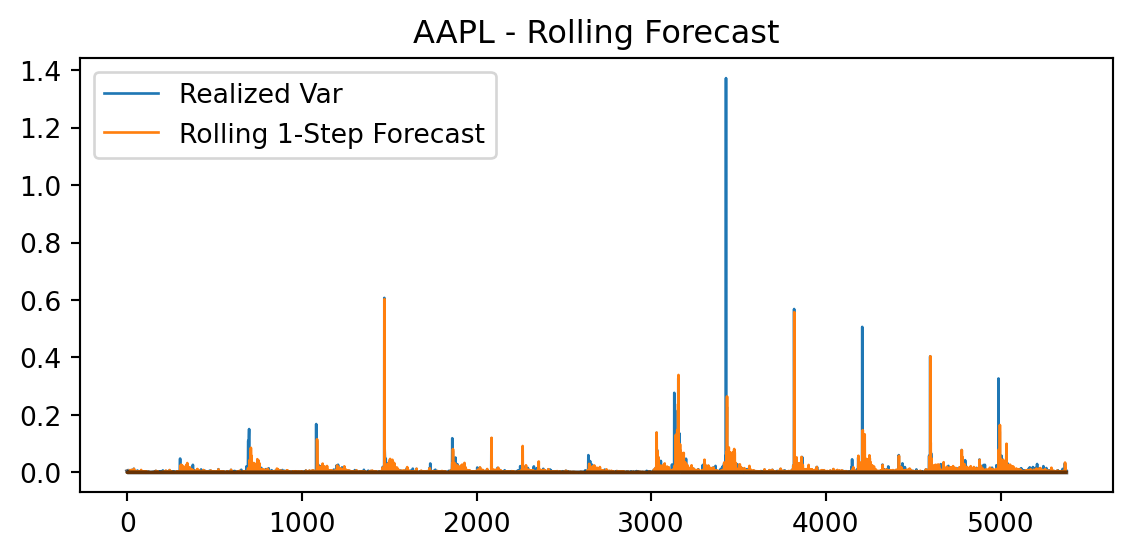

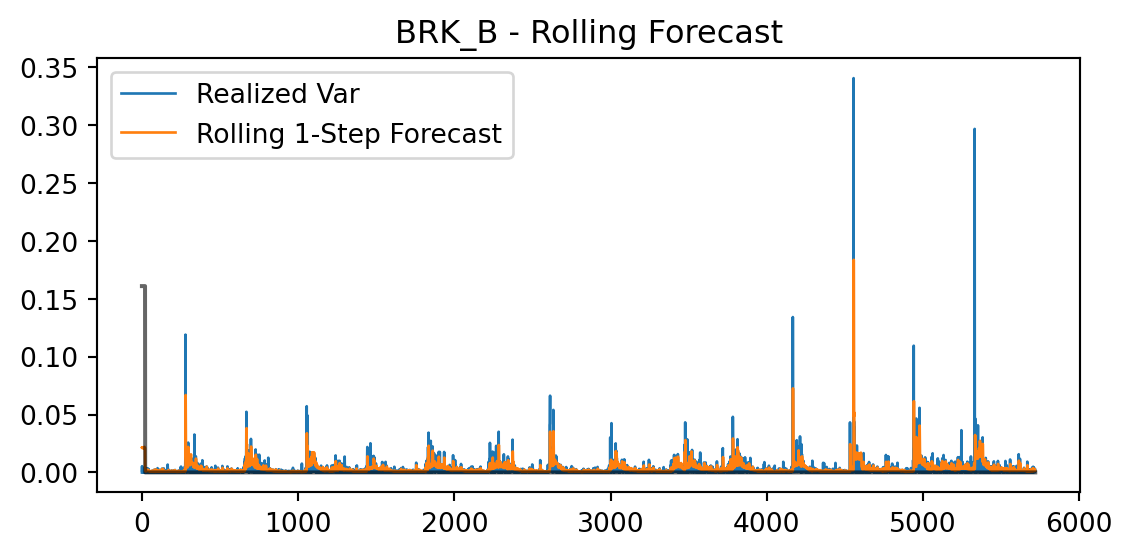

In [11]:
tickers = ["AAPL","BRK_B","JPM","LUMN","MPC","OXY"]
tickers = ["AAPL","BRK_B"]
yg_roll = []
import matplotlib.pyplot as plt
rolling_forecasts = {}
rolling_residuals = {}
for t in tickers:
    r = np.asarray(globals()[f"r_{t}"], float)
    f_roll = []
    prev_theta = theta0.copy()
    regime = []
    for i in range(7100, len(r)):       
        r_sub = r[i-50:i]   # forecast uses same r as in third last line r**2                
        res = minimize(nll_ms_garch, prev_theta, args=(r_sub, 2), method='L-BFGS-B')
        theta_i = prev_theta if (not res.success or not np.isfinite(res.fun)) else res.x
        prev_theta = theta_i
        f_next, reg = forecast_var_k(r_sub, theta_i, R=2, k=1)    # new output regime
        
        # ALSO A SEPARATE GARCH(1,1)
        garch = arch_model(r_sub, vol='Garch', p=1, q=1, dist='normal', rescale= False).fit(disp='off')
        yg_pred = garch.forecast(horizon=1).variance.values[-1, 0]
        yg_roll.append(yg_pred)

        regime.append(reg[-1])
        f_roll.append(f_next[0])
        globals()[f"regime_{t}"] = regime
    
    globals()[f"yg_pred_{t}"] = [yg_pred]


    if len(f_roll) > 0:
        f_roll = np.array(f_roll)
        y_true = r[-len(f_roll):]**2
        globals()[f"y_true_{t}"] = y_true
        globals()[f"y_pred_{t}"] = f_roll
        rolling_residuals[t] = y_true - f_roll

    plt.figure(figsize=(6,3))
    plt.plot(r[-len(f_roll):]**2, label="Realized Var", linewidth=1)
    plt.plot(f_roll, label="Rolling 1-Step Forecast", linewidth=1)
    if len(regime) > 0 and np.array(regime).ndim ==2:
        plt.plot(np.array(regime)[:,1] * 0.9 * plt.ylim()[1], color='black', alpha=0.6) 
        # Printing probability betweeen scaled 0 - 0.6
    plt.title(f"{t} - Rolling Forecast"); plt.legend(); plt.tight_layout(); plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def metrics(y_true, y_pred, eps=1e-10):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    m = min(len(y_true), len(y_pred))
    y_true, y_pred = y_true[-m:], np.clip(y_pred[-m:], eps, None)

    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)

    # Gaussian log score per obs (constant included); many papers drop the constant
    nll  = 0.5 * np.mean(np.log(2*np.pi*y_pred) + y_true / y_pred)

    # Paper-comparable losses:
    qlike   = np.mean(y_true / y_pred - np.log(y_true / y_pred + eps) - 1.0)
    log_mse = np.mean((np.log(y_true + eps) - np.log(y_pred))**2)

    bias = float(np.mean(y_true - y_pred))
    return {"RMSE": rmse, "MAE": mae, "NLL": nll, "QLIKE": qlike, "logMSE": log_mse, "Bias": bias}

results = {}
results_garch = {}

for t in tickers:
    y_true = globals()[f"y_true_{t}"] 
    y_pred = globals()[f"y_pred_{t}"]
    yg_pred = globals()[f"yg_pred_{t}"]
    
    results[t] = metrics(y_true, y_pred)
    results_garch[t] = metrics(y_true, yg_pred)

table = pd.DataFrame(results, index=["RMSE","MAE","NLL","Mean","QLIKE", "LogMSE", "Bias"]).T.round(4)
table_g = pd.DataFrame(results_garch, index=["RMSE","MAE","NLL","Mean","QLIKE","LogMSE","Bias"]).T.round(4)

# table = table.sort_values(by= "RMSE", ascending= True)

print("MS-GARCH results:\n", table)
print("\nVanilla GARCH(1,1) results:\n", table_g)

MS-GARCH results:
          RMSE     MAE         NLL  Mean       QLIKE  LogMSE    Bias
AAPL   0.0302  0.0063  13534.6176   NaN  27074.2006     NaN  0.0002
BRK_B  0.0087  0.0030     -1.7394   NaN      1.8849     NaN -0.0012

Vanilla GARCH(1,1) results:
          RMSE     MAE     NLL  Mean   QLIKE  LogMSE    Bias
AAPL   0.0031  0.0031 -0.9615   NaN  0.3096     NaN  0.0031
BRK_B  0.0007  0.0007 -2.1269   NaN  0.1779     NaN -0.0007
